In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini")

### Create Supervisor Agent

In [2]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command


members = ["web_researcher"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["web_researcher","FINISH"]


def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

In [10]:
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast
from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import BaseTool
from typing_extensions import Annotated, TypedDict
 
from langgraph.errors import ErrorCode, create_error_message
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.types import Checkpointer
from langgraph.utils.runnable import RunnableCallable
from typing import  Literal,List,Any
class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[list[Any], add_messages]
    new_value: str

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
      return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    graph = graph_builder.compile()
    return graph

In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Optional, List, Dict
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain.agents import create_agent
from langgraph.types import Command
from langchain_core.tools import tool, InjectedToolCallId
 
@tool(
    "web_search_tool",
    description="web_search_tool: Use this tool when user shows any symptom or asks for appointment.",
)
def web_search_tool(
    query: str,
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    return Command(update={
        "new_value": "This is an extra value",
        "messages": [
            ToolMessage(
                content="I'm share the list of the specialty please select one of them for booking appointment.",             
                tool_call_id=tool_call_id
            )
        ]
    })


In [15]:
websearch_agent = create_agent(llm, [web_search_tool])
def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            # "new_value": "This is an extra value111",
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

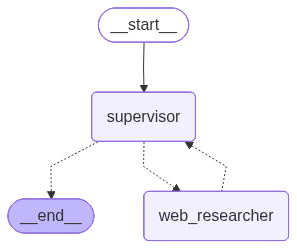

In [16]:
builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
graph = builder.compile()
graph

In [17]:
initial_state = {
    "messages": [HumanMessage(content="I have fever and backpain from last night")], 
    "new_value": None 
     
}
import uuid
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

response = graph.invoke(initial_state, config=config)
response

Next Worker: web_researcher
Next Worker: FINISH


{'messages': [HumanMessage(content='I have fever and backpain from last night', additional_kwargs={}, response_metadata={}, id='5e9df1c1-581c-44c2-86b5-d40d045b3cdc'),
  HumanMessage(content="It seems I am having difficulty retrieving specific information on doctors for your symptoms. However, I recommend that you seek medical attention promptly, especially since you're experiencing fever and back pain.\n\nYou can visit a nearby clinic or hospital, or consult a general practitioner who can provide the necessary treatment for both your symptoms. If you'd like, I can assist you in searching for specific specialties or clinics once those details are provided.", additional_kwargs={}, response_metadata={}, name='web_researcher', id='60ab5ddb-2c04-46a3-b3cd-502d448f47c6')],
 'new_value': None}